# Facial composites - Generate images of suspects

<a href="https://en.wikipedia.org/wiki/Facial_composite">Facial composites</a> are widely used in forensics to generate images of suspects. Since victim or witness usually isn't good at drawing, computer-aided generation is applied to reconstruct the face attacker. One of the most commonly used techniques is evolutionary systems that compose the final face from many predefined parts.

In this project, we will try to implement an app for creating a facial composite that will be able to construct desired faces without explicitly providing databases of templates. We will apply Variational Autoencoders and Gaussian processes for this task.

In [1]:
!nvidia-smi

Sun Apr 12 22:59:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   26C    P8     6W / 180W |      1MiB / 16278MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [35]:
import os
import tqdm
import gdown
import numpy as np
import matplotlib.pyplot as plt
import GPyOpt
import tensorflow as tf
from IPython.display import clear_output

# Download data

We used Aligned & Cropped version of CelebA you can be found <a href="http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html">here</a> to pretrain VAE model.

The data contents 202,599 colored jpg images of size `(218, 178, 3)`.

In [3]:
if not os.path.exists('./data'):
    !mkdir ./data

In [4]:
%%time
# https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=sharing
url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM'
output = './data/img_align_celeba.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
To: /notebooks/Facial-Composites/data/img_align_celeba.zip
1.44GB [00:26, 54.4MB/s]

CPU times: user 3.76 s, sys: 4.56 s, total: 8.32 s
Wall time: 32.1 s


'./data/img_align_celeba.zip'

In [5]:
%%time
!unzip -q ./data/img_align_celeba.zip -d ./data/
!rm -r ./data/img_align_celeba.zip

CPU times: user 575 ms, sys: 164 ms, total: 738 ms
Wall time: 29.6 s


In [6]:
print(f"Number of images: {len(os.listdir('./data/img_align_celeba')):,}")

Number of images: 202,599


# Pretrain VAE

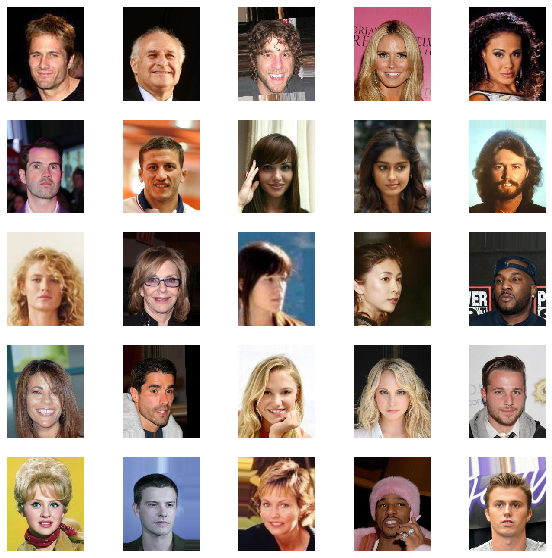

In [7]:
plt.figure(figsize=(10, 10))
for i in range(1, 26):
    filename = os.path.join('./data/img_align_celeba', '{:06d}.jpg'.format(i+3000))
    img = plt.imread(filename)
    plt.subplot(5, 5, i)
    plt.imshow(img)
    plt.axis('off')

## Define VAE Models

In [8]:
class VAE(tf.keras.Model):

    def __init__(self, img_shape, n_filters, n_layers, latent_size):
        super(VAE, self).__init__()
        
        w = img_shape[0] // 2**n_layers
        h = img_shape[1] // 2**n_layers
        c = n_filters * 2**(n_layers - 1)
        
        # Encoder
        self.encoder = tf.keras.Sequential()
        self.encoder.add(tf.keras.layers.InputLayer(img_shape))
        for i in range(n_layers):
            self.encoder.add(tf.keras.layers.Conv2D(filters=n_filters * 2**i, kernel_size=(5, 5),
                                                        strides=(2, 2), padding='same', use_bias=False))
            self.encoder.add(tf.keras.layers.BatchNormalization(axis=3))
            self.encoder.add(tf.keras.layers.Activation(tf.nn.relu))
        self.encoder.add(tf.keras.layers.Reshape([w * h * c]))
        self.encoder.add(tf.keras.layers.Dense(2 * latent_size))
        
        # Decoder
        self.decoder = tf.keras.Sequential()
        self.decoder.add(tf.keras.layers.InputLayer([latent_size]))
        self.decoder.add(tf.keras.layers.Dense(w * h * c))
        self.decoder.add(tf.keras.layers.Reshape([w, h, c]))
        for i in range(n_layers - 1, 0, -1):
            self.decoder.add(tf.keras.layers.Conv2DTranspose(filters=n_filters * 2**i, kernel_size=(5, 5),
                                                             strides=(2, 2), padding='same', use_bias=False))
            self.decoder.add(tf.keras.layers.BatchNormalization(axis=3))
            self.decoder.add(tf.keras.layers.Activation(tf.nn.relu))
        self.decoder.add(tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5, 5),
                                                         strides=(2, 2), padding='same'))

        self.get_mean = tf.keras.layers.Lambda(lambda latent: latent[:, :latent_size])
        self.get_log_var = tf.keras.layers.Lambda(lambda latent: latent[:, latent_size:])
        
    def sample(self, mean, log_var):
        """
        Sampling from the distribution q(t | x) = N(t_mean, exp(t_log_var)) with reparametrization trick.
        :params
            mean: Tensor[batch_size, latent_size]
            log_var: Tensor[batch_size, latent_size]
        
        :return
            Tensor[batch_size, latent_size]
        """
        var = tf.exp(log_var * 0.5)
        epsilon = tf.random.normal(tf.shape(mean), mean=0, stddev=1)
        z = mean + var * epsilon
        return z

    def call(self, inputs):
        """
        :params
            inputs: Tensor[batch_size, width, height, channel]

        :return
            inputs_reconstructed: Tensor[batch_size, width, height, channel]
            t_mean: Tensor[batch_size, latent_size]
            t_log_var: Tensor[batch_size, latent_size]
        """
        mean_log_var = self.encoder(inputs)
        mean = self.get_mean(mean_log_var)
        log_var = self.get_log_var(mean_log_var)
        z = self.sample(mean, log_var)
        inputs_reconstructed = self.decoder(z)
        return inputs_reconstructed, mean, log_var

## Loss Function

In [9]:
def vlb(inputs, inputs_reconstructed, mean, log_var, reconstruction_weight=1000):
    """
    Variational Lower Bound
    :params
        inputs: Tensor[batch_size, width, height, channel]
        inputs_reconstructed: Tensor[batch_size, width, height, channel]
        mean: Tensor[batch_size, latent_size]
        log_var: Tensor[batch_size, latent_size]

    :return
        Tensor[]
    """
    reconstructed_loss = tf.reduce_mean(tf.metrics.mean_squared_error(inputs, inputs_reconstructed))
    KL_loss = - tf.reduce_mean(
        0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
    )
    loss = reconstruction_weight * reconstructed_loss + KL_loss
    return loss

## Training routines

In [10]:
@tf.function
def train_step(model, optimizer, loss_func, inputs):
    """Pass through a batch"""
    with tf.GradientTape() as tape:
        inputs_reconstructed, mean, log_var = model(inputs)
        loss = loss_func(inputs, inputs_reconstructed, mean, log_var)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function
def valid_step(model, loss_func, inputs):
    """Pass through a batch"""
    inputs_reconstructed, mean, log_var = model(inputs)
    loss = loss_func(inputs, inputs_reconstructed, mean, log_var)
    return loss

In [11]:
def train(model, optimizer, loss_function, train_data, valid_data, n_epochs, batch_size, checkpoint, checkpoint_directory):
    assert callable(loss_function)
    
    if not os.path.exists(checkpoint_directory):
        !mkdir {checkpoint_directory}
        
    checkpoint_prefix  = os.path.join(checkpoint_directory, 'vae_ckpt') # For checkpointing
    
    history = {'loss': [], 'val_loss': []}
    train_data = train_data.shuffle(100)
    train_data = train_data.batch(batch_size)
    train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)
    
    valid_data = valid_data.batch(batch_size)
    valid_data = valid_data.prefetch(tf.data.experimental.AUTOTUNE)
    
    best_loss = [float('inf')]
    n_batches_per_epoch = (len(img_list[:-VALID_SIZE]) // batch_size) + 1 # Global variable
    n_valid_batches = (len(img_list[-VALID_SIZE:]) // batch_size) + 1 # Global variable

    status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_directory))
    for epoch in range(n_epochs):
        epoch_text = f'Epoch: {epoch + 1:02d} - '
        
        # Training
        loss = 0.
        train_pbar = tqdm.tqdm(enumerate(train_data), total=n_batches_per_epoch)
        for i, data in train_pbar:
            loss += train_step(model, optimizer, loss_function, data)
            train_pbar.set_description(epoch_text + f'loss:     {loss.numpy()/(i+1):.3f}')
        history['loss'].append(loss.numpy() / n_batches_per_epoch)
            
        # Validation
        val_loss = 0.
        val_pbar = tqdm.tqdm(enumerate(valid_data), total=n_valid_batches)
        for i, data in val_pbar:
            val_loss += valid_step(model, loss_function, data)
            val_pbar.set_description(epoch_text + f'val_loss: {val_loss.numpy()/(i+1):.3f}')
        history['val_loss'].append(val_loss.numpy() / n_valid_batches)
        
        # Saving
        if history['val_loss'][-1] < best_loss[-1]:
            best_loss.append(history['val_loss'][-1])
            # status.assert_consumed() # Sanity checks.
            checkpoint.save(file_prefix=checkpoint_prefix)
        
    print()
        
    return history

## Prepare data

In [12]:
VALID_SIZE = 5000
IMG_SHAPE = (64, 64)

In [13]:
def load(img_fn, img_shape=IMG_SHAPE):
    filepath = tf.strings.join(['./data/img_align_celeba', img_fn], separator='/')
    contents = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(contents, channels=3)
    img = img[45:-45, 25:-25]
    img = tf.image.resize(img, img_shape)
    img = tf.cast(img, tf.float32) / 256
    return img

In [14]:
img_list = os.listdir('./data/img_align_celeba')

train_dataset = tf.data.Dataset.from_tensor_slices(img_list[:-VALID_SIZE])
valid_dataset = tf.data.Dataset.from_tensor_slices(img_list[-VALID_SIZE:])

In [15]:
train_dataset = train_dataset.map(load, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.map(load, num_parallel_calls=tf.data.experimental.AUTOTUNE)

(25, 64, 64, 3)


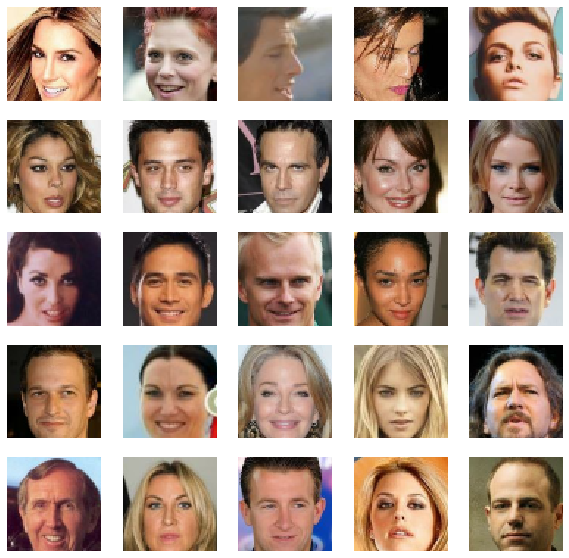

In [16]:
for img in train_dataset.batch(25):
    print(img.shape)
    plt.figure(figsize=(10, 10))
    for i in range(1, 26):
        plt.subplot(5, 5, i)
        plt.imshow(img[i-1, :, :].numpy())
        plt.axis('off')
    break

## Train VAE model

In [17]:
N_FILTERS = 64
N_LAYERS = 4
LATENT_SIZE = 8

In [18]:
tf.keras.backend.clear_session()
vae_model = VAE(img_shape=(*IMG_SHAPE, 3),
                n_filters=N_FILTERS,
                n_layers=N_LAYERS,
                latent_size=LATENT_SIZE)
optimizer = tf.optimizers.Adam()
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=vae_model)

In [19]:
BATCH_SIZE = 128
N_EPOCHS = 10
CKPT_DIR = './checkpoints'

In [20]:
%%time
history = train(model=vae_model,
                optimizer=optimizer,
                loss_function=vlb,
                train_data=train_dataset,
                valid_data=valid_dataset,
                n_epochs=N_EPOCHS,
                batch_size=BATCH_SIZE,
                checkpoint=checkpoint,
                checkpoint_directory=CKPT_DIR)

Epoch: 10 - val_loss: 29.934: 100%|██████████| 40/40 [00:02<00:00, 14.59it/s]



CPU times: user 56min 58s, sys: 19min 16s, total: 1h 16min 14s
Wall time: 41min 47s


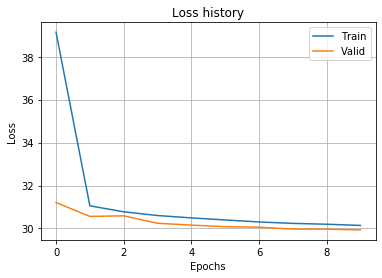

In [21]:
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Valid')
plt.title('Loss history')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate Faces

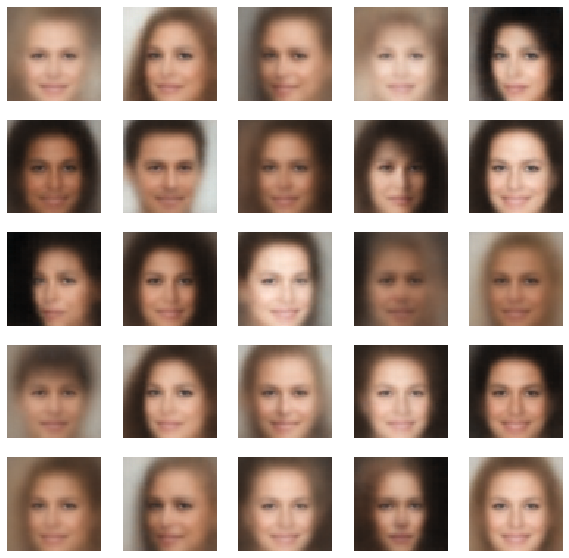

In [25]:
### 25 samples
img_samples = vae_model.decoder(tf.random.normal((25, LATENT_SIZE))).numpy()
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.clip(img_samples[i], 0, 1))
    plt.axis('off')
plt.show()

# Search Procedure

Now that we have a way to reconstruct images, we need to set up an optimization procedure to find a person that will be the most similar to the one we are thinking about. To do so, we need to set up some scoring utility.

Let's imagine that we want to generate an image of Brad Pitt. We start with a small number of random samples, say 5, and rank them according to their similarity to our vision of Brad Pitt: 1 for the worst, 5 for the best. We then rate image by image using `GPyOpt` that works in a latent space of VAE. For the new image, we need to somehow assign a real number that will show how good this image is. The simple idea is to ask a user to compare a new image with previous images (along with their scores). A user then enters score to a current image.

In [48]:
class FacialComposite:
    
    def __init__(self, decoder, latent_size):
        self.latent_size = latent_size
        self.decoder = decoder
        self.samples = None
        self.images = None
        self.rating = None
        
    def _get_image(self, latent):
        img = self.decoder(latent[None, :].astype(np.float32)).numpy()[0]
        img = np.clip(img, 0, 1)
        return img
    
    @staticmethod
    def _show_images(images, titles):
        assert len(images) == len(titles)
        clear_output()
        plt.figure(figsize=(3*len(images), 3))
        n = len(titles)
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.imshow(images[i])
            plt.title(str(titles[i]))
            plt.axis('off')
        plt.show()
        
    @staticmethod
    def _draw_border(image, w=2):
        bordred_image = image.copy()
        bordred_image[:, :w] = [1, 0, 0]
        bordred_image[:, -w:] = [1, 0, 0]
        bordred_image[:w, :] = [1, 0, 0]
        bordred_image[-w:, :] = [1, 0, 0]
        return bordred_image
    
    def query_initial(self, n_start=10, select_top=5):
        """
        Creates initial points for Bayesian optimization
        Generate `n_start` random images and asks user to rank them.
        Gives maximum score to the best image and minimum to the worst.
        
        :param
            n_start: number of images to rank initialy.
            select_top: number of images to keep
        """
        samples = np.random.randn(n_start, self.latent_size)
        images = np.array([self._get_image(samples[i]) for i in range(n_start)])
        
        self._show_images(images, range(n_start))
        print('Initial points for Bayesian Optimization')
        print(f'Please select the top {select_top} images which are more likely to what you think')
        print('Eg: 5 9 3 0 7 1')
        rates = input('Your rates: ')
        ranks = [*map(int, rates.split())]        
        
        self.samples = samples[ranks]
        self.images = images[ranks]
        self.rating = np.arange(n_start, 0, -n_start / select_top)

        # Check that tensor sizes are correct
        np.testing.assert_equal(self.rating.shape, [select_top])
        np.testing.assert_equal(self.images.shape, [select_top, 64, 64, 3])
        np.testing.assert_equal(self.samples.shape, [select_top, self.latent_size])
        
    def _compare(self, candidate_image, current_image):
        self._show_images([candidate_image, current_image], ['Candidate image', 'Current image'])
        print('Is the candidate image better than current image? [y/n] ')
        response = input().lower()
        while response not in ['y', 'n']:
            print('Please enter y or n: ')
            response = input().lower()
        return response == 'y'
        
    def evaluate(self, candidate):
        """
        Query candidate vs known image set.
        Adds candidate into images pool.
        :param
            candidate: latent vector of size [1, latent_size]
            
        :return float
        """
        initial_size = len(self.images)
        
        candidate = candidate[0]
        candidate_image = self._get_image(candidate)
        
        low = 0
        high = initial_size
        while low < high:
            mid = (low + high) // 2
            if self._compare(candidate_image, self.images[mid]):
                high = mid
            else:
                low = mid + 1
                
        if low == 0:
            candidate_rating = (10 + self.rating[0]) / 2
        elif low == initial_size:
            candidate_rating = (self.rating[-1] + 0) / 2
        else:
            candidate_rating = (self.rating[low - 1] + self.rating[low]) / 2
        
        self.samples = np.insert(self.samples, low, candidate, axis=0)
        self.images = np.insert(self.images, low, candidate_image, axis=0)
        self.rating = np.insert(self.rating, low, candidate_rating, axis=0)
        
        assert len(self.images) == initial_size + 1
        assert len(self.rating) == initial_size + 1
        assert len(self.samples) == initial_size + 1
        return candidate_rating
    
    def optimize(self, n_iter=10, w=4, acquisition_type='MPI', acquisition_par=0.3):
        if self.samples is None:
            self.query_initial()

        bounds = [{'name': 'z_{0:03d}'.format(i),
                   'type': 'continuous',
                   'domain': (-w, w)} 
                  for i in range(self.latent_size)]
        optimizer = GPyOpt.methods.BayesianOptimization(f=self.evaluate, domain=bounds,
                                                        acquisition_type = acquisition_type,
                                                        acquisition_par = acquisition_par,
                                                        exact_eval=False, # Since we are not sure
                                                        model_type='GP',
                                                        X=self.samples,
                                                        Y=self.rating[:, None],
                                                        maximize=True)
        optimizer.run_optimization(max_iter=n_iter, eps=-1)
        
    def get_best(self):
        index_best = np.argmax(self.rating)
        return self.images[index_best]

    def draw_best(self, title=''):
        index_best = np.argmax(self.rating)
        image = self.images[index_best]
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
        plt.show()

# Testing procedure

### Finding person with darkest hair

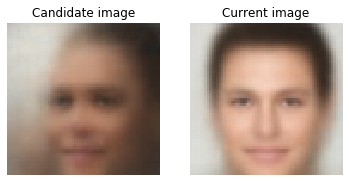

Is the candidate image better than current image? [y/n] 


 n


In [49]:
composite = FacialComposite(vae_model.decoder, 8)
composite.optimize()

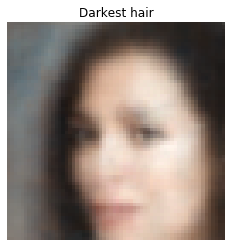

In [50]:
composite.draw_best('Darkest hair')

### Finding person with the widest smile

composite = FacialComposite(vae_model.decoder, 8)
composite.optimize()

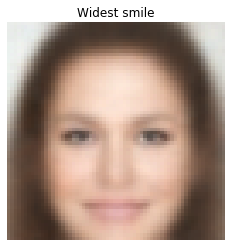

In [53]:
composite.draw_best('Widest smile')

### Finding Justin Trudeau

In [55]:
composite = FacialComposite(vae_model.decoder, 8)
composite.optimize()